In [1]:
import os
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature
from skimage import exposure
from skimage.feature import hog
import dlib

In [2]:
# Define emotion labels corresponding to subdirectories
emotion_labels = {'anger':0, 'disgust':1, 'fear':2, 'happy':3, 'sadness':4, 'surprise':5, 'contempt':6}
# Define a mapping dictionary from numeric labels to emotion names
emotion_names = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', 6: 'contempt'}

In [3]:
# Define the root directory where the CK+ dataset images are stored
# Adjust the path to the actual dataset directory
dataset_dir = './CK/'

In [4]:
# Initialize empty lists to store image data and labels
images = []
labels = []
hog_images = []
hog_features = []

In [5]:
# Iterate through subdirectories and load images and labels
for emotion, label in emotion_labels.items():
    subdirectory_path = os.path.join(dataset_dir, emotion)
    
    # Iterate through images in each subdirectory
    for image_filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, image_filename)
        
        # Open and preprocess the image (you may need to resize or convert to grayscale)
        multi_channel_image = cv2.imread(image_path)
        
        #multi_channel_image = cv2.cvtColor(multi_channel_image, cv2.COLOR_BGR2GRAY)
        
        multi_channel_image = cv2.resize(multi_channel_image, (48, 48))
        
        image = np.mean(multi_channel_image, axis=2).astype(np.uint8)
        
        
        # Append the image and its label to the lists
        image = np.array(image)  # Convert to NumPy array if needed
        images.append(image)
        labels.append(label)  # Convert emotion label to integer

In [6]:
# Convert lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)
num_samples = len(images)

# Check the shapes of the arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (981, 48, 48)
Labels shape: (981,)


In [7]:
images[0].shape

(48, 48)

In [8]:
count = [0,0,0,0,0,0,0]
for i in range(num_samples):
    count[labels[i]] = count[labels[i]] + 1
for i in range(7):
    print(count[i])

135
177
75
207
84
249
54


In [9]:
# Iterate through the selected sample indices
for i in range(num_samples):
    original_image = images[i]
    hog_feature, hog_image = hog(original_image, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range(0,5))
    hog_features.append(hog_feature)
    hog_images.append(hog_image)

In [10]:
# Convert the list of HOG images to a NumPy array
hog_images = np.array(hog_images)

# Now, 'hog_images' contains the HOG representations of all images
print("HOG Images shape:", hog_images.shape)

HOG Images shape: (981, 48, 48)


In [11]:
# You can access individual original and LBP images by indexing the arrays
# For example, to access the first original and LBP images:
index = random.randint(0, num_samples-1)
original_image = images[index]
hog_image = hog_images[index]
numeric_label = labels[index]
# Get the emotion name or 'Unknown' if not found
emotion_name = emotion_names.get(numeric_label, 'Unknown')

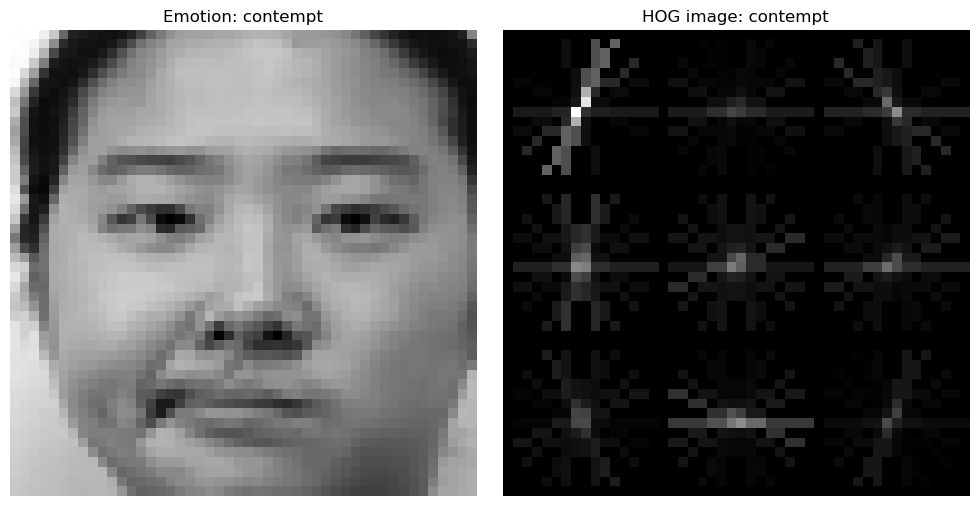

In [12]:
# Create subplots for the random image and its LBP representation
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

# Display the original image
ax_original = axes[0]
ax_original.imshow(original_image, cmap='gray')
ax_original.set_title(f"Emotion: {emotion_name}")
ax_original.axis('off')
    
# Display the LBP representation
ax_lbp = axes[1]
ax_lbp.imshow(hog_image, cmap='gray')
ax_lbp.set_title(f"HOG image: {emotion_name}")
ax_lbp.axis('off')
 
plt.tight_layout()
plt.show()

In [ ]:
hog_features

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Assuming 'hog_features' contains HOG feature vectors
# Assuming 'labels' contains corresponding emotion labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

In [16]:
# Initialize and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [17]:
# Make predictions on the test data
y_pred_train = svm_classifier.predict(X_train)

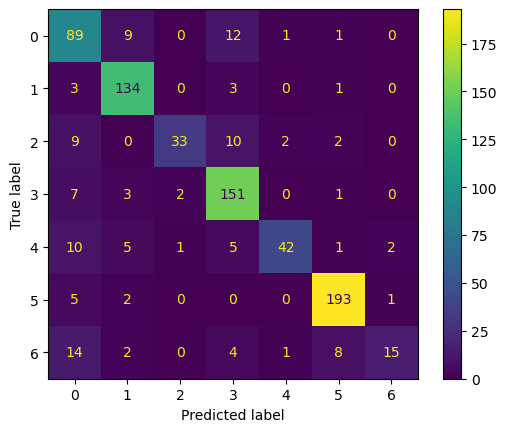

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred_train, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

In [19]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 0.8380102040816326
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71       112
           1       0.86      0.95      0.91       141
           2       0.92      0.59      0.72        56
           3       0.82      0.92      0.87       164
           4       0.91      0.64      0.75        66
           5       0.93      0.96      0.95       201
           6       0.83      0.34      0.48        44

    accuracy                           0.84       784
   macro avg       0.85      0.74      0.77       784
weighted avg       0.85      0.84      0.83       784



In [20]:
# Make predictions on the test data
y_pred_test = svm_classifier.predict(X_test)

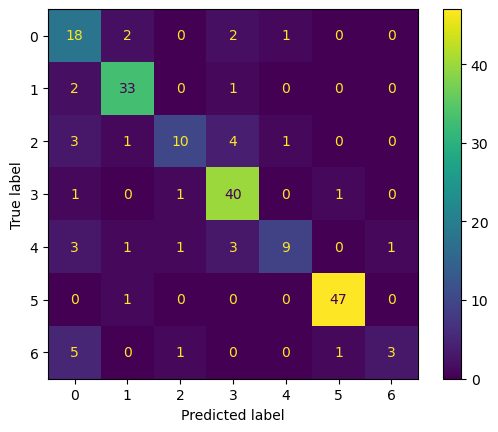

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.8121827411167513
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.78      0.65        23
           1       0.87      0.92      0.89        36
           2       0.77      0.53      0.62        19
           3       0.80      0.93      0.86        43
           4       0.82      0.50      0.62        18
           5       0.96      0.98      0.97        48
           6       0.75      0.30      0.43        10

    accuracy                           0.81       197
   macro avg       0.79      0.70      0.72       197
weighted avg       0.82      0.81      0.80       197



In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(64,128), activation='relu', solver='adam', max_iter=750, random_state=1)
clf.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(64, 128), max_iter=750, random_state=1)

In [24]:
y_pred_train = clf.predict(X_train)

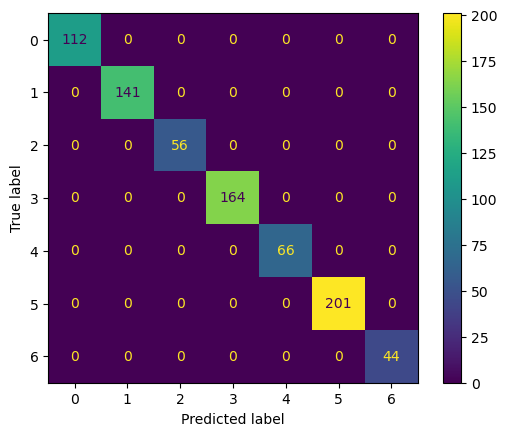

In [25]:
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       141
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00        66
           5       1.00      1.00      1.00       201
           6       1.00      1.00      1.00        44

    accuracy                           1.00       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      1.00      1.00       784



In [27]:
y_pred_test  = clf.predict(X_test)

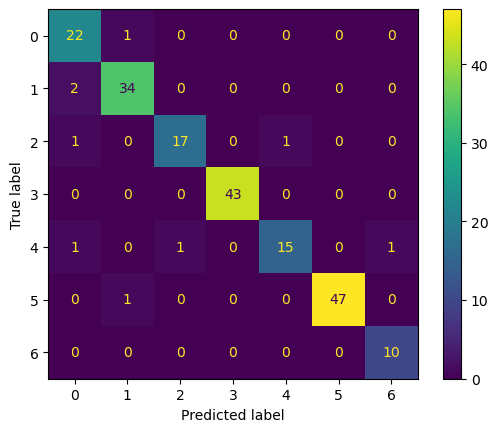

In [28]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.9543147208121827
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90        23
           1       0.94      0.94      0.94        36
           2       0.94      0.89      0.92        19
           3       1.00      1.00      1.00        43
           4       0.94      0.83      0.88        18
           5       1.00      0.98      0.99        48
           6       0.91      1.00      0.95        10

    accuracy                           0.95       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.96      0.95      0.95       197

